# Navigation
---


In [1]:
from mlagents_envs.environment import UnityEnvironment as UE
import numpy as np
import torch
import random
from collections import deque
from dqn_agent import Agent
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ENV_PATH = "environment-MAC/en.app"

### 1. Initialise customised Banana Collecter environment

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
def initialise_env(ENV_PATH):
    # env = UnityEnvironment(file_name=ENV_PATH)
    env = UE(base_port=5004,file_name=ENV_PATH, seed=1, side_channels=[])
    env.step()
    # in this project, we are only using one agent, so we will only work on the first `brain` in the environmet
    # get the default brain
    # brain_name = env.brain_names[0]
    brain_name = list(env.behavior_specs.keys())[0]
    # brain = env.brains[brain_name]
    brain = env.behavior_specs[brain_name]
    return env, brain, brain_name

In [4]:
# env = UE(file_name=ENV_PATH, seed=1, side_channels=[])

In [5]:
# test = env.behavior_specs.keys()
# print(list(test)[0])
# for t in test:
#     print(t)

In [6]:
# brain_name = list(env.behavior_specs.keys())[0]
# print(brain_name)

In [7]:
# brain = env.behavior_specs[brain_name]

In [8]:
env, brain, brain_name = initialise_env(ENV_PATH)

E0614 16:07:11.126702000 8640914944 fork_posix.cc:76]                  Other threads are currently calling into gRPC, skipping fork() handlers


[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [9]:
# print(brain_name)

In [10]:
# 先让他走几步直到需要交互
# env.step()

### State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 



### 2. Initialise the agent

In [11]:
spec = env.behavior_specs['My Behavior?team=0']
print(spec)

BehaviorSpec(observation_specs=[ObservationSpec(shape=(84, 84, 3), dimension_property=(<DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.NONE: 1>), observation_type=<ObservationType.DEFAULT: 0>, name='CameraSensor'), ObservationSpec(shape=(0,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='VectorSensor'), ObservationSpec(shape=(4,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='VectorSensor_size4')], action_spec=ActionSpec(continuous_size=0, discrete_branches=(5,)))


In [12]:
# reset the environment
#env_info = env.reset(train_mode=True)[brain_name]
env_info = env.reset()
#action_size = brain.vector_action_space_size
#state_size = len(env_info.vector_observations[0])
#agent = Agent(state_size=state_size, action_size=action_size, seed=0)

In [13]:
print(env_info)

None


In [14]:
action_size = list(brain.action_spec)[1][0]

In [15]:
# change
# decision_steps.obs[0].shape

In [16]:
print(brain.observation_specs)

[ObservationSpec(shape=(84, 84, 3), dimension_property=(<DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.NONE: 1>), observation_type=<ObservationType.DEFAULT: 0>, name='CameraSensor'), ObservationSpec(shape=(0,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='VectorSensor'), ObservationSpec(shape=(4,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='VectorSensor_size4')]


In [17]:
state_size = len(brain.observation_specs[0])

In [18]:
#state_size = len(env_info.vector_observations[0])
# state size 要改
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

### 3. Train agent

In [19]:
# import torchvision.transforms as transforms
actions = []
for act in range(5):
    actions.append(spec.action_spec.empty_action(1))
    actions[act].add_discrete(np.int32([[act]]))
stop = actions[0]
forward = actions[1]
backward = actions[2]
turn_right = actions[3]
turn_left = actions[4]
def train_dqn(agent, n_episodes=2, max_t=10, eps_start=1.0, eps_end=0.1, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    rewards =0
    reward =0
    for i_episode in range(1, n_episodes+1):
        decision_steps, terminal_steps = env.get_steps(brain_name)
        state = np.moveaxis(decision_steps.obs[0], -1, 0)
        tracked_agent = -1
        done = False
        score = 0
        for t in range(max_t):
            if tracked_agent == -1 and len(decision_steps) >= 1:
                tracked_agent = decision_steps.agent_id[0]
            if not state.shape == (3, 1, 84, 84):
                continue
                
            action = agent.act(state, eps)
            env.set_actions(brain_name, actions[action])
            env.step()
            decision_steps, terminal_steps = env.get_steps(brain_name)
            
            next_state = np.moveaxis(decision_steps.obs[0], -1, 0)   # get the next state
            
            if tracked_agent in decision_steps:# The agent requested a decision
                reward += decision_steps[tracked_agent].reward  # get the reward
                agent.step(state, action, reward, next_state, False)
            if tracked_agent in terminal_steps: # The agent terminated its episode
                rewards += terminal_steps[tracked_agent].reward# get the reward
                agent.step(state, action, reward, next_state, True)
                break
            state = next_state
            score += reward
            
        print(score)
        scores_window.append(score)       # save most recent score
        print(scores_window)
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
#         if i_episode % 100 == 0:
#             print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
#             torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
#             print('saved temporary learned weight')
#         if np.mean(scores_window)>=13.0:
#             print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
#             torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
#             print('agent done training')
#             break
    return scores


In [ ]:
if os.path.isfile('./checkpoint.pth'):
    # load the weights from file
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    
scores = train_dqn(agent, n_episodes=100)

100.0
deque([100.0], maxlen=100)
Episode 1	Average Score: 100.0095.0
deque([100.0, 95.0], maxlen=100)
Episode 2	Average Score: 97.5084.0
deque([100.0, 95.0, 84.0], maxlen=100)
Episode 3	Average Score: 93.0073.0
deque([100.0, 95.0, 84.0, 73.0], maxlen=100)
Episode 4	Average Score: 88.0070.0
deque([100.0, 95.0, 84.0, 73.0, 70.0], maxlen=100)
Episode 5	Average Score: 84.4070.0
deque([100.0, 95.0, 84.0, 73.0, 70.0, 70.0], maxlen=100)
Episode 6	Average Score: 82.0066.0
deque([100.0, 95.0, 84.0, 73.0, 70.0, 70.0, 66.0], maxlen=100)
Episode 7	Average Score: 79.7150.0
deque([100.0, 95.0, 84.0, 73.0, 70.0, 70.0, 66.0, 50.0], maxlen=100)
Episode 8	Average Score: 76.00110.0
deque([100.0, 95.0, 84.0, 73.0, 70.0, 70.0, 66.0, 50.0, 110.0], maxlen=100)
Episode 9	Average Score: 79.78150.0
deque([100.0, 95.0, 84.0, 73.0, 70.0, 70.0, 66.0, 50.0, 110.0, 150.0], maxlen=100)
Episode 10	Average Score: 86.80150.0
deque([100.0, 95.0, 84.0, 73.0, 70.0, 70.0, 66.0, 50.0, 110.0, 150.0, 150.0], maxlen=100)
Episod

Episode 42	Average Score: 180.10290.0
deque([100.0, 95.0, 84.0, 73.0, 70.0, 70.0, 66.0, 50.0, 110.0, 150.0, 150.0, 150.0, 139.0, 127.0, 110.0, 110.0, 110.0, 110.0, 110.0, 110.0, 110.0, 104.0, 90.0, 85.0, 78.0, 80.0, 220.0, 260.0, 260.0, 260.0, 350.0, 360.0, 360.0, 360.0, 352.0, 341.0, 326.0, 310.0, 294.0, 290.0, 290.0, 290.0, 290.0], maxlen=100)
Episode 43	Average Score: 182.65290.0
deque([100.0, 95.0, 84.0, 73.0, 70.0, 70.0, 66.0, 50.0, 110.0, 150.0, 150.0, 150.0, 139.0, 127.0, 110.0, 110.0, 110.0, 110.0, 110.0, 110.0, 110.0, 104.0, 90.0, 85.0, 78.0, 80.0, 220.0, 260.0, 260.0, 260.0, 350.0, 360.0, 360.0, 360.0, 352.0, 341.0, 326.0, 310.0, 294.0, 290.0, 290.0, 290.0, 290.0, 290.0], maxlen=100)
Episode 44	Average Score: 185.09290.0
deque([100.0, 95.0, 84.0, 73.0, 70.0, 70.0, 66.0, 50.0, 110.0, 150.0, 150.0, 150.0, 139.0, 127.0, 110.0, 110.0, 110.0, 110.0, 110.0, 110.0, 110.0, 104.0, 90.0, 85.0, 78.0, 80.0, 220.0, 260.0, 260.0, 260.0, 350.0, 360.0, 360.0, 360.0, 352.0, 341.0, 326.0, 310.

#### 4. Plot performance

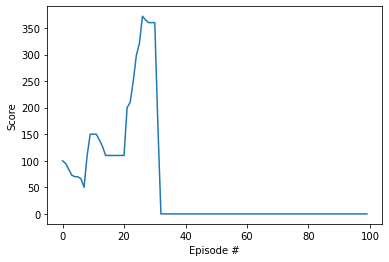

In [31]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a trained agent!

In [33]:
# def watch_banana_agent(agent, env, n_episodes=4, n_steps=300):

                                   
    
#     for episode in range(n_episodes):
        
#         env_info = env.reset(train_mode=False)[brain_name] # reset the environment
#         state = env_info.vector_observations[0]            # get the current state
#         score = 0                                          # initialize the score
        
#         for step in range(n_steps):

#             action = agent.act(state)                 # select an action
#             env_info = env.step(action)[brain_name]        # send the action to the environment
#             next_state = env_info.vector_observations[0]   # get the next state
#             reward = env_info.rewards[0]                   # get the reward
#             done = env_info.local_done[0]                  # see if episode has finished
#             score += reward                                # update the score
#             state = next_state                             # roll over the state to next time step
#             if done:                                       # exit loop if episode finished
#                 break

#         print("Score: {}".format(score))

In [34]:
# watch_banana_agent(agent, env)

TypeError: reset() got an unexpected keyword argument 'train_mode'

In [15]:
env.close()